In [1]:
import numpy as np
import numpy.random as ra
import numpy.linalg as la
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
print(os.getcwd())

/home/riccardo/RESEARCH_code/online2SLS


### Utils

In [2]:
def sherman_morrison(invA, u, v):
    d = u.shape[0]
    u = u.reshape(d,1)
    v = v.reshape(d,1)
    return  (invA - (invA @ u @ v.T @ invA)/(1 + v.T @ invA @ u))
    
def calc_sqrt_b_ridge(k,sigma_2,lamda,delta,S_hat,logdetG):
    '''Returns confidence interval width for ridge regression'''
    return sigma_2 * np.sqrt( logdetG - k * np.log(lamda) + np.log(1/(delta**2)) ) + np.sqrt(lamda) * S_hat 

def calc_sqrt_b_2sls(k,sigma_2,lamda,delta,S_hat,logdetG):
    '''Returns confidence interval width for 2SLS regression'''
    return sigma_2 * np.sqrt( logdetG - k * np.log(lamda) + np.log(1/(delta**2)) )

def runit(Z, X, Y, beta_star, S_hat, sigma_1, sigma_2,lamda, lamda_IV, delta, seed, eps, pulled_indeces, algorithm='ridge'):
    '''function used to run an instance of linear bandits using OFUL with ridge or 2SLS regression'''
    np.random.seed(42)
    nb_exp, T, nb_actions, d = X.shape
    regret = np.zeros((nb_exp,T))
    pred_norms = np.zeros((nb_exp,T))
    x_inv_norms = np.zeros((nb_exp,T))
    norm_betasHat_beta = np.zeros((nb_exp, T))
    beta_hat_ridge_rec = np.zeros((nb_exp,T,d))
    beta_hat_2sls_rec = np.zeros((nb_exp,T,d))
    ThetaHat_rec = np.zeros((nb_exp,T, d, d))
        
    for i in tqdm(range(nb_exp)):
        
        Gxx, invGxx = lamda*np.eye(d), np.eye(d)/lamda
        ZXt = lamda_IV*np.eye(d)
        invZXt = np.eye(d)/lamda_IV
        Zyt = np.zeros(d)
        Gzz, invGzz = 1e4*np.eye(d), np.eye(d)/lamda # is the regularizer correct here???
        invThetaHat = np.eye(d)/lamda   
        logdetG = d*np.log(lamda)
        Xyt = np.zeros(d) 
        sqrt_b_ridge = calc_sqrt_b_ridge(d, sigma_2, lamda, delta, S_hat, logdetG)
        sqrt_b_2sls = calc_sqrt_b_2sls(d, sigma_2, lamda, delta, S_hat, logdetG)
        beta_hat_ridge = np.zeros(d)
        beta_hat_2sls = np.zeros(d)

        for t in range(T):
            z = Z[i,t]
            x = X[i,t]
            y = Y[i,t]
   
            if algorithm == 'ridge':
                X_invGt_norm_sq = np.sum(np.dot(x, invGxx) * x, 1)
                x_inv_norms[i,t] = max(X_invGt_norm_sq)
                norm_betasHat_beta[i,t] = np.linalg.norm(beta_hat_ridge-beta_star)
                preds = np.dot(x, beta_hat_ridge)
                pred_norms[i,t] = np.linalg.norm(preds)
                obj = preds + sqrt_b_ridge * np.sqrt(X_invGt_norm_sq) 

            if algorithm == '2sls':
                X_invThetaHat_invGt_invThetaHatT_norm_sq = np.sum((x @ invThetaHat @ invGzz @ invThetaHat.T) * x,1)
                # X_invGt_norm_sq = np.sum(np.dot(x, invGxx) * x, 1) ###
                # X_invThetaHat_invGt_invThetaHatT_norm_sq = np.sum((x @ inv_theta_star @ invGzz @ inv_theta_star.T) * x,1)
                # x_inv_norms[i,t] = max(X_invThetaHat_invGt_invThetaHatT_norm_sq)
                preds = np.dot(x, beta_hat_2sls)
                norm_betasHat_beta[i,t] = np.linalg.norm(beta_hat_2sls-beta_star)
                # preds = np.dot(x, beta_star) ####
                pred_norms[i,t] = np.linalg.norm(preds)
                obj = preds + sqrt_b_2sls * np.sqrt(X_invThetaHat_invGt_invThetaHatT_norm_sq) 
                # obj = preds + sqrt_b_ridge * np.sqrt(X_invGt_norm_sq)  ####


            # Pull the arm with the highest estimated value
            pulled_idx = np.argmax(obj)  
            pulled_indeces[i,t] = pulled_idx 
            xt = x[pulled_idx, :]
            zt = z[pulled_idx, :]
            yt = y[pulled_idx]
            # compute regret 
            # regret[i,t] = np.max(np.dot(x, beta_star))-np.dot(xt, beta_star) # maybe I should change this definition of regret
            # regret[i,t] = np.max(y) - yt # maybe I should change this definition of regret
            regret[i,t] = np.max(y) - yt

            # build estimators
            if algorithm == 'ridge':
                Xyt += xt*yt
                Gxx += np.outer(xt, xt)
                tempval1 = np.dot(invGxx, xt)    # d by 1, O(d^2)
                tempval2 = np.dot(tempval1, xt)      # scalar, O(d)
                logdetG += np.log(1 + tempval2)
                if (t % 20 == 0):
                    invGxx = np.linalg.inv(Gxx)
                else:
                    invGxx -= np.outer(tempval1, tempval1) / (1 + tempval2) 
                beta_hat_ridge = np.dot(invGxx, Xyt)
                sqrt_b_ridge = calc_sqrt_b_ridge(d, sigma_2, lamda, delta, S_hat, logdetG)
                beta_hat_ridge_rec[i,t, :] = beta_hat_ridge
                # print(beta_hat_ridge)
            
            if algorithm == '2sls': # check all inverse here
                Gxx += np.outer(xt, xt)
                Gzz += np.outer(zt, zt)  # ????? regularizer here is it correct
                Zyt += zt*yt
                Xyt += xt*yt
                ZXt += np.outer(zt, xt)

                tempval1 = np.dot(invGzz, zt)    # d by 1, O(d^2)
                tempval2 = np.dot(tempval1, zt)      # scalar, O(d)
                logdetG += np.log(1 + tempval2)
                empval1 = np.dot(invGxx, xt)    # d by 1, O(d^2)
                empval2 = np.dot(empval1, xt)      # scalar, O(d)
                logdetG += np.log(1 + empval2)
                if (t % 20 == 0) or (t<2*d):
                    invGxx = np.linalg.inv(Gxx)
                    invZXt = np.linalg.inv(ZXt)
                    invGzz = np.linalg.inv(Gzz)
                else:
                    invGxx -= np.outer(empval1, empval1) / (1 + empval2)
                    # invGxx = sherman_morrison(invGxx, xt, xt)
                    invZXt = sherman_morrison(invZXt, zt, xt)
                    invGzz -= np.outer(tempval1, tempval1) / (1 + tempval2) 
                    # invGzz = sherman_morrison(invGzz, zt, zt) 

                beta_hat_2sls = np.dot(invZXt, Zyt)
                ThetaHat = invGzz @ ZXt
                invThetaHat =  np.linalg.inv(ThetaHat)
                sqrt_b_2sls = calc_sqrt_b_2sls(d, sigma_2, lamda, delta, S_hat, logdetG)
                ThetaHat_rec[i,t, :, :] = ThetaHat 
                beta_hat_2sls_rec[i,t, :] = beta_hat_2sls    
                # print(beta_hat_2sls)

            
    if algorithm == 'ridge':
        return regret, pred_norms, x_inv_norms, beta_hat_ridge_rec, ThetaHat_rec, norm_betasHat_beta
    elif algorithm == '2sls':   
        return regret, pred_norms, x_inv_norms, beta_hat_2sls_rec, ThetaHat_rec, norm_betasHat_beta
    else:
        print("error")


### Experiments

In [3]:
S, sigma_1, sigma_2 = 1, 0.01, 0.0001
T, n_a, d = int(1e3), 200, 20
lamda = 1 #1/T
lamda_IV = 1e-3
delta = 0.001
seed = 1996
S_hat = S
nb_exp = 100
pulled_indeces = np.zeros((nb_exp,T))


In [4]:
theta_star = np.random.randn(d,d); #  theta_star *= 1/np.linalg.norm(theta_star) #maybe this can be changed
inv_theta_star = np.linalg.inv(theta_star)
beta_star = np.random.multivariate_normal([10 for i in range(d)], np.eye(d)).reshape(-1,) ; beta_star *= S/np.linalg.norm(beta_star)

# first stage
# X_max = 100
Z = np.random.randn(nb_exp, T, n_a, d) #; Z /= np.max(np.linalg.norm(Z,axis=2))/X_max
eps = sigma_1*np.random.randn(nb_exp, T, n_a, d)
# eps = np.zeros((T,d))
X = np.dot(Z, theta_star) + eps

# second stage
ee = d//4
eta_tilde = np.random.randn(nb_exp, T, n_a) 
# eta = (eta_tilde + np.sum(eps[:,:,:,:ee]))/(1+ee*sigma_1)*sigma_2
eta = sigma_2 * (eta_tilde + eps[:,:,:,:ee].sum(axis=-1))
X = X / np.max(np.linalg.norm(X, axis=3, keepdims = True), axis=2, keepdims=True) 
Y = np.dot(X, beta_star) + eta

In [5]:
algorithms = ['ridge','2sls']
labels = ['OFUL$^{r}$','OFUL$^{f}$']
# colors = ['blue','darkviolet','darkorange']#,'darkred']
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
# s_colors = ['cyan','violet','orange']#,'red']

In [6]:
regrets = np.zeros((nb_exp,len(algorithms),T))
pred_norms = np.zeros((nb_exp,len(algorithms),T))
x_inv_norms = np.zeros((nb_exp,len(algorithms),T))
# beta_hat_ridge = np.zeros((nb_exp,T,d))
beta_hat = np.zeros((nb_exp, len(algorithms), T,d))
theta_hat = np.zeros((nb_exp, len(algorithms), T, d, d))
beta_error = np.zeros((nb_exp, len(algorithms), T))

for i,a in enumerate(algorithms):
    regrets[:,i,:], pred_norms[:,i,:], x_inv_norms[:,i,:], beta_hat[:, i, :,:] , theta_hat[:, i, :,:, :], beta_error[:,i,:] = runit(Z, X, Y, beta_star, S_hat, sigma_1, sigma_2, lamda, lamda_IV, delta, seed, eps, pulled_indeces, a)

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


In [7]:
# print("||beta - beta|| = ", np.linalg.norm((beta_star-beta_star).mean(axis=0)))
print("||betaHat_ridge - beta|| = ", np.linalg.norm((beta_hat[:, 0, -1, :]-beta_star).mean(axis=0)))
print("||betaHat_IV - beta|| = ", np.linalg.norm((beta_hat[:, 1, -1, :]-beta_star).mean(axis=0)))

# print(np.linalg.norm((theta_star - np.array([0.]))))
# print(np.linalg.norm((theta_hat[:, 0, -1, :, :]-theta_star).mean(axis=0)))
print("||thetaHat - theta|| = ", np.linalg.norm((theta_hat[:, 1, -1, :, :]-theta_star).mean(axis=0)))

# mean_beta_ridge = beta_hat[:, 0, -1, :].mean(axis=0)
# mean_beta_2sls = beta_hat[:, 1, -1, :].mean(axis=0)
# print(beta_star) 
# print(mean_beta_ridge) 
# print(mean_beta_2sls)

||betaHat_ridge - beta|| =  0.596028998707504
||betaHat_IV - beta|| =  9.019565721579184e-05
||thetaHat - theta|| =  21.099094065278333


In [8]:
pulled_indeces

array([[128., 113.,  84., ...,  32., 102.,  77.],
       [162., 106.,  38., ...,   0.,  83.,  50.],
       [  0., 164., 175., ..., 111.,  57.,  58.],
       ...,
       [169., 126., 119., ..., 158.,  49.,  64.],
       [181.,   8., 109., ..., 125.,  72.,  89.],
       [ 27., 125., 111., ..., 140.,  54.,  18.]])

### Regret

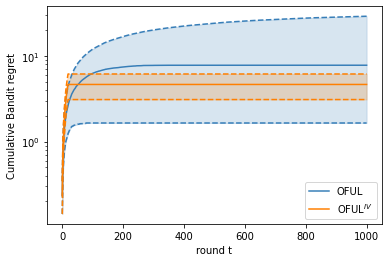

<Figure size 432x288 with 0 Axes>

In [9]:
mean_regret = np.cumsum(regrets.mean(axis=0),axis=1)
std_regret = np.cumsum(regrets.std(axis=0),axis=1)


fst_quantile_regret = np.cumsum(np.quantile(regrets,0.25,axis=0),axis=1)
scd_quantile_regret = np.cumsum(np.quantile(regrets,0.5,axis=0),axis=1)
thd_quantile_regret = np.cumsum(np.quantile(regrets,0.75,axis=0),axis=1)
# _ = np.log(lamda+(X_max**2)*np.arange(1,T+1)/d)

labels = ['OFUL','OFUL$^{IV}$']

for i,a in enumerate(algorithms):
#     plt.plot(np.divide(mean_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),label=labels[i],color=colors[i])
    # plt.plot(mean_regret[i],label=labels[i],color=colors[i])
#     plt.fill_between(np.arange(T),np.divide(fst_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),np.divide(thd_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),color=colors[i],alpha=0.2)
    plt.fill_between(np.arange(T),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_regret[i],color=colors[i],linestyle="solid", label = labels[i])
    plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
    # plt.fill_between(np.arange(T),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.1)
# log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("round t")
plt.ylabel('Cumulative Bandit regret')
# plt.xlim([0,50])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.show()
plt.savefig("cumulative_regret.pdf", format='pdf')

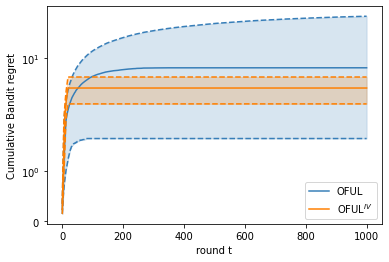

<Figure size 432x288 with 0 Axes>

In [10]:
start = 0
mean_regret = np.cumsum(regrets.mean(axis=0)[:,start:] ,axis=1)
std_regret = np.cumsum(regrets.std(axis=0)[:,start:],axis=1)

fst_quantile_regret = np.cumsum(np.quantile(regrets[:,:,start:],0.25,axis=0),axis=1)
scd_quantile_regret = np.cumsum(np.quantile(regrets[:,:,start:],0.5,axis=0),axis=1)
thd_quantile_regret = np.cumsum(np.quantile(regrets[:,:,start:],0.75,axis=0),axis=1)

labels = ['OFUL','OFUL$^{IV}$']

for i,a in enumerate(algorithms):
#     plt.plot(np.divide(mean_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),label=labels[i],color=colors[i])
    # plt.plot(mean_regret[i],label=labels[i],color=colors[i])
    # plt.fill_between(np.arange(T-start),np.divide(fst_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),np.divide(thd_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),color=colors[i],alpha=0.2)
    plt.fill_between(np.arange(T-start),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_regret[i],color=colors[i],linestyle="solid", label = labels[i])
    plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
    # plt.fill_between(np.arange(T-start),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.1)
# log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('symlog')
plt.xlabel("round t")
plt.ylabel('Cumulative Bandit regret')
# plt.xlim([0,50])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.show()
plt.savefig("cumulative_regret_warm_start.pdf", format='pdf')

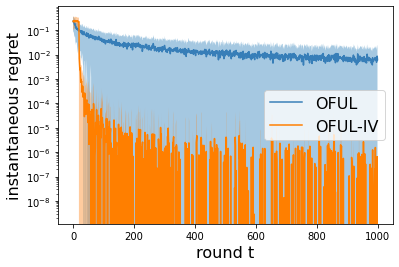

In [37]:
mean_regret = regrets.mean(axis=0)
std_regret = regrets.std(axis=0)


fst_quantile_regret = np.quantile(regrets,0.25,axis=0)
scd_quantile_regret = np.quantile(regrets,0.5,axis=0)
thd_quantile_regret = np.quantile(regrets,0.75,axis=0)
# _ = np.log(lamda+(X_max**2)*np.arange(1,T+1)/d)

labels = ['OFUL','OFUL-IV']

for i,a in enumerate(algorithms):
    plt.plot(mean_regret[i],label=labels[i],color=colors[i])
    plt.fill_between(np.arange(T),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.4)

    # plt.fill_between(np.arange(T),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    # plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    # plt.plot(scd_quantile_regret[i],color=colors[i],linestyle="solid", label = labels[i])
    # plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
# log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("round t")
plt.ylabel('instantaneous regret')
# plt.xlim([0,50])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.savefig("B_instantaneous_regret.pdf", format='pdf')

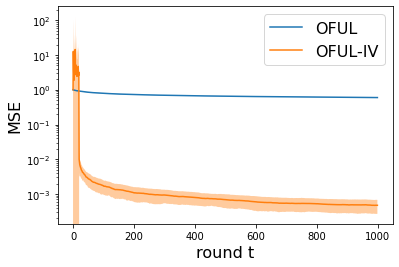

In [38]:
mean_beta_errors = beta_error.mean(axis=0)
std_beta_errors = beta_error.std(axis=0)

fst_quantile_beta_error = np.quantile(beta_error,0.25,axis=0)
scd_quantile_beta_error = np.quantile(beta_error,0.5,axis=0)
thd_quantile_beta_error = np.quantile(beta_error,0.75,axis=0)

labels = ['OFUL','OFUL-IV']
for i,a in enumerate(algorithms):
    plt.plot(mean_beta_errors[i,:], label= labels[i])
    plt.fill_between(np.arange(T),mean_beta_errors[i]-std_beta_errors[i],mean_beta_errors[i]+std_beta_errors[i],alpha=0.4)

    # plt.fill_between(np.arange(T),fst_quantile_beta_error[i],thd_quantile_beta_error[i],color=colors[i],alpha=0.2)
    # plt.plot(fst_quantile_beta_error[i],color=colors[i],linestyle="dashed")
    # plt.plot(scd_quantile_beta_error[i],color=colors[i],linestyle="solid", label = labels[i])
    # plt.plot(thd_quantile_beta_error[i],color=colors[i],linestyle="dashed")
plt.legend()
plt.xlabel("round t")
plt.ylabel('MSE')
plt.yscale("log")
plt.savefig("B_beta_error.pdf", format='pdf')

In [36]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title